# TP3
Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en `Material_TPs/TP3/images` a partir del template `Material_TPs/TP3/template`

1. (4 puntos) Obtener una detección del logo en cada imagen sin falsos positivos
2. (4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen coca_multi.png con el mismo témplate del item 2
3. (2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes.

Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza de la detección.

In [1]:
import numpy as np
import cv2 as cv
import time
import matplotlib
import matplotlib.pyplot as plt
import os
import imutils
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)

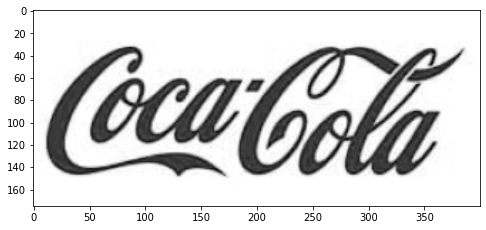

In [2]:
# Cargamos el template
template = cv.imread('./template/pattern.png',0)
plt.imshow(template, cmap="gray")

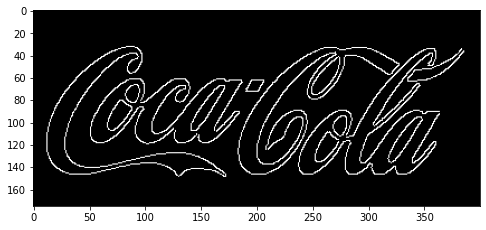

In [3]:
template_edges = cv.Canny(template, 220, 260, apertureSize = 3)
plt.imshow(template_edges, cmap="gray")
plt.show()

SCORE: 0.8459779354885424


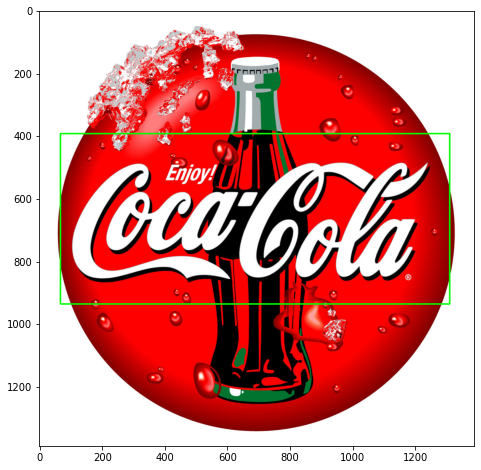

AVERAGE SCORE: 0.7157144248485565


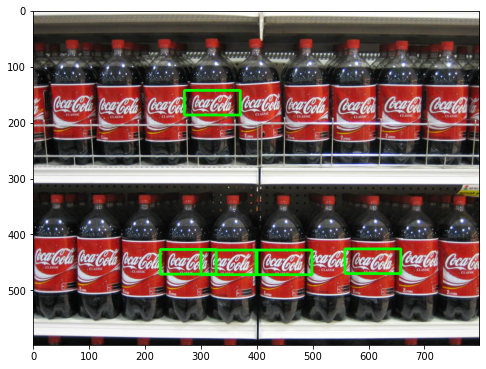

SCORE: 0.914635022935749


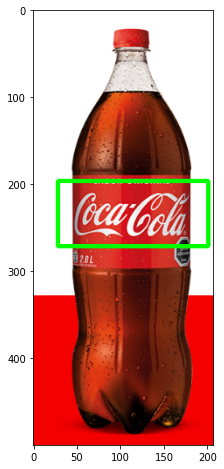

SCORE: 0.714755405445233


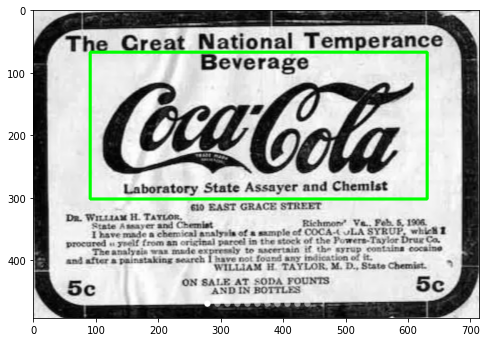

SCORE: 0.7982077200206371


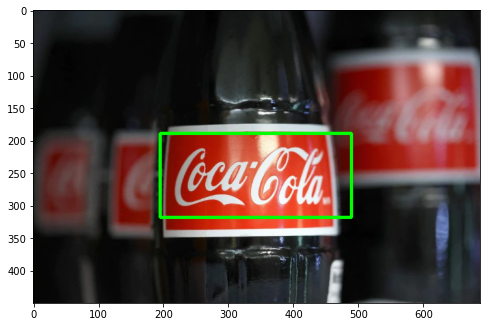

SCORE: 0.7657756541901227


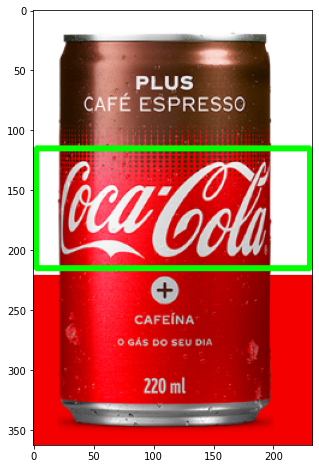

SCORE: 0.8393118422632159


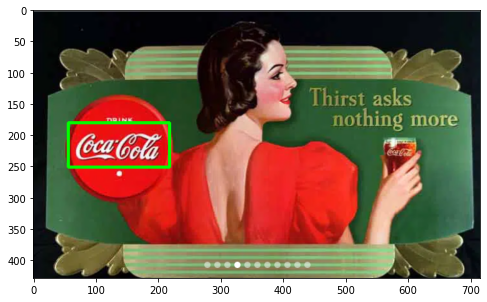

In [4]:
def match_template_canny(img, template, minVal, maxVal, apertureSize, method=cv.TM_CCOEFF):
    edged = cv.Canny(img, minVal, maxVal, apertureSize)
    result = cv.matchTemplate(edged, template, method) #TM_CCOEFF
    min_val, maxVal, minLoc, maxLoc = cv.minMaxLoc(result)
    return min_val, maxVal, minLoc, maxLoc, result

def draw_rectangles(image, locations, scale, template_height, template_width, color=(0, 255, 0), multiple=False):
    if not multiple:
        location = locations
        (startX, startY) = (int(location[0] * scale), int(location[1] * scale))
        (endX, endY) = (int((location[0] + template_width) * scale), int((location[1] + template_height) * scale))
        cv.rectangle(image, (startX, startY), (endX, endY), color, 3)
    else:
        for location in zip(*locations[::-1]):
            (startX, startY) = (int(location[0] * scale), int(location[1] * scale))
            (endX, endY) = (int((location[0] + template_width) * scale), int((location[1] + template_height) * scale))
            cv.rectangle(image, (startX, startY), (endX, endY), color, 3)
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.show()


def template_matching(template, images_path, threshold=0.7):
    for img_name in os.listdir(images_path):
        
        image = cv.imread(images_path + img_name, cv.COLOR_BGR2RGB)
        gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        (tH, tW) = template.shape[:2]
        found = None
        
        for scale in np.linspace(0.05, 2.5, 100)[::-1]: 
            resized = imutils.resize(gray, width = int(gray.shape[1] * scale))
            r = gray.shape[1] / float(resized.shape[1])
            if resized.shape[0] < tH or resized.shape[1] < tW:
                break
            min_val, maxVal, minLoc, maxLoc, result = match_template_canny(resized, template, 200, 250, 3, 
                                                                            cv.TM_CCOEFF)
            if found is None or maxVal > found[0]:
                score = maxVal/(maxVal-min_val)
                found = (maxVal, maxLoc, r, score)
        if found and found[3] >= threshold:
            (maxVal, maxLoc, r, score) = found
            print("SCORE:", score)
            draw_rectangles(image, maxLoc, r, tH, tW)
        else:
            found = False
            # print("making image bigger")
            predictions = list()
            predictions_count = 0
            best_r = 1
            for scale in np.linspace(1, 2.8, 10)[::-1]: 
                resized = imutils.resize(gray, width = int(gray.shape[1] * scale))
                r = gray.shape[1] / float(resized.shape[1])

                for template_scale in np.linspace(0.1, 1, 10)[::-1]:
                    template_resized = imutils.resize(template, width = int(template.shape[1] * template_scale))
                    (tH, tW) = template_resized.shape[:2]
                    if resized.shape[0] < tH or resized.shape[1] < tW:
                        break
                    min_val, maxVal, minLoc, maxLoc, result = match_template_canny(resized, template_resized, 
                                                                                    200, 210, 3,
                                                                                    cv.TM_CCOEFF)
                    result = result/(maxVal-min_val)
                    loc = np.where(result >= threshold)
                    if len(loc[0]) > predictions_count:
                        predictions_count = len(loc[0])
                        score = 0
                        for maxLoc in zip(*loc[::-1]):
                            score += result[maxLoc[1]][maxLoc[0]]
                        score = score/predictions_count
                        print("AVERAGE SCORE:", score)
                        draw_rectangles(image, loc, r, tH, tW, multiple=True)
                        found = True
                if found:
                    break
        
images_path = "./images/"
template = template_edges
template_matching(template, images_path)